# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

In [81]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd

data = pd.read_csv('dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
X.shape[0]

13150

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
#Implementando código del arbol, del código 04-Decision Trees

In [207]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [208]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [209]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [210]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [211]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [212]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [213]:
y_pred=tree_predict(X_test,tree)

In [214]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred, normalize=True)

0.8433179723502304

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [215]:
#Construccion de las muestras para cada arbol 
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [216]:
# se construyen los 10 arboles 
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [217]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0,0,0,0,1,1,0,1,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [218]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [219]:
accuracy_score(y_test, y_pred, normalize=True)

0.8423963133640553

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

#### con max_features = al numero de variables (9)

In [228]:
max_features = len(X.columns)

In [229]:
#Se modifica la funcion best_split para que tome una muestra del numero de variables en cada split 


def best_split_rf(X, y, f, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    sample=random.sample(features,f)
    
    # For all features
    for j in sample:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [239]:
#Se modifica la funcion tree_grow para que utilice la nueva funcion best_split_rf

def tree_grow_rf(X, y, max_features, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split_rf(X, y, max_features, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, max_features=max_features, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow_rf(X_l, y_l, max_features, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow_rf(X_r, y_r, max_features, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [241]:
tree1 = tree_grow_rf(X_train, y_train, max_features, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [242]:
y_pred=tree_predict(X_test,tree1)

In [245]:
accuracy_score(y_test, y_pred, normalize=True)

0.8435483870967742

In [507]:
# list of values to try for max_features
max_features_range = range(1, len(X.columns))

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

for f in max_features_range:
    tree = tree_grow_rf(X_train, y_train, f, level=0, min_gain=0.001, max_depth=None, num_pct=10)
    y_pred=tree_predict(X_test,tree)  
    accuracy_scores.append(accuracy_score(y_test, y_pred, normalize=True))

In [508]:
results = {'values':max_features_range, 'accuracy': accuracy_scores}
res = pd.DataFrame(data=results)
res

,values,accuracy
0,1,0.827880
1,2,0.834562
2,3,0.871889
3,4,0.871429
4,5,0.873502
5,6,0.872120
6,7,0.864286
7,8,0.857373


# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [558]:
n_features=len(X.columns)

In [559]:
max_features = int(np.log(n_features))

In [560]:
#Construccion de las muestras para cada arbol 
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [561]:
trees = {}
for i in range(n_estimators):
    trees[i] = tree_grow_rf(X_train.iloc[samples[i]], y_train.iloc[samples[i]], max_features, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [562]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test,trees[i])

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [563]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [564]:
accuracy_score(y_test, y_pred, normalize=True)

0.8732718894009217

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [432]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy').mean()

C:\Users\caang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.842388449714581

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

#### Calculating best value for  n_estimators

In [565]:
# findind the best n_estimators 
# list of values to try for n_estimators
estimator_range = range(10, 200, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

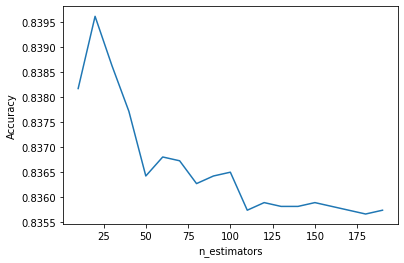

In [84]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

#### Calculating best value for  max_features

In [89]:
X.columns

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [90]:
feature_cols = X.columns

In [93]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=25, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

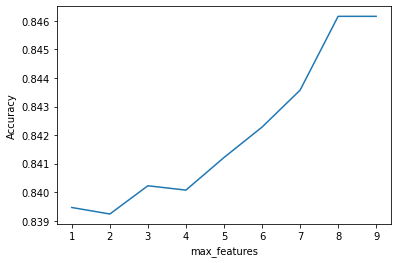

In [94]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

#### Calculating best value  for  Max_depth 

In [95]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

for depth in max_depth_range:
    clf =  RandomForestClassifier(max_depth=depth, n_estimators=25,max_features=8, random_state=1,n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

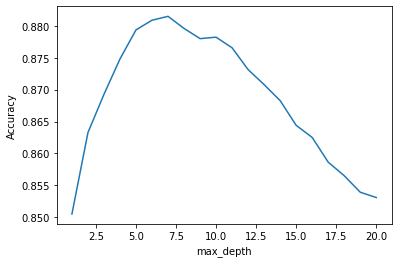

In [97]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [98]:
# model with the optimized parameters 
clf_optimizado =  RandomForestClassifier(max_depth=7, n_estimators=25, max_features=8, random_state=1,n_jobs=-1)
clf_optimizado.fit(X_train, y_train)
cross_val_score(clf_optimizado, X_test, y_test, cv=5, scoring='accuracy').mean()

0.8783392920364299

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [104]:
from xgboost import XGBClassifier
from sklearn import metrics
xg = XGBClassifier()
xg

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [107]:
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
metrics.accuracy_score(y_pred, y_test.values)

0.8790322580645161

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

#### Estimating the best value for gamma  

Gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.


In [566]:
# definiendo el gamma 
gamma_range = range(0, 100, 10)

# list to store the average RMSE 
accuracy_scores = []

for g in gamma_range:
    xg =  XGBClassifier(gamma=g)
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))


Text(0, 0.5, 'Accuracy')

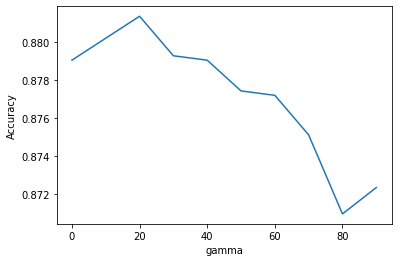

In [110]:
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

#### Estimating best value for colsample_bytree

colsample_bytree: colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

In [172]:
# defining colsample_bytree
col_range = np.arange(0, 1, 0.05)

# list to store the average RMSE
accuracy_scores = []

for col in col_range:
    xg =  XGBClassifier(gamma=20, colsample_bytree=col )
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))

Text(0, 0.5, 'Accuracy')

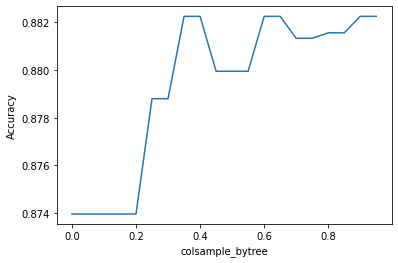

In [173]:
plt.plot(col_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

In [174]:
results1 = {'values':col_range, 'accuracy': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,accuracy
0,0.00,0.873963
1,0.05,0.873963
2,0.10,0.873963
3,0.15,0.873963
4,0.20,0.873963
5,0.25,0.878802
6,0.30,0.878802
7,0.35,0.882258
8,0.40,0.882258
9,0.45,0.879954


#### Estimating best value for learning rate

learning_rate(eta):Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

In [175]:
# findinf best value for learning_rate
learning_rate_range = np.arange(0, 1, 0.1)

# list to store the average RMSE
accuracy_scores = []

for lr in learning_rate_range:
    xg =  XGBClassifier(gamma=20, colsample_bytree=0.4, eta=lr )
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test.values))

Text(0, 0.5, 'Accuracy')

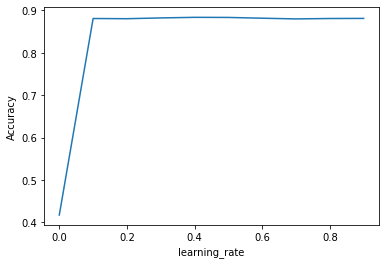

In [176]:
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

In [177]:
results = {'values':learning_rate_range, 'accuracy': accuracy_scores}
res = pd.DataFrame(data=results)
res

,values,accuracy
0,0.0,0.417512
1,0.1,0.880876
2,0.2,0.880415
3,0.3,0.882258
4,0.4,0.883641
5,0.5,0.883410
6,0.6,0.881567
7,0.7,0.879954
8,0.8,0.880876
9,0.9,0.881106


In [178]:
# XGB optimizado 

xg_op =  XGBClassifier(gamma=20, colsample_bytree=0.4, eta=0.4 )
xg_op.fit(X_train, y_train)
y_pred = xg_op.predict(X_test)
metrics.accuracy_score(y_pred, y_test.values)

0.8836405529953917